# Résolution du modèle proie-prédateur discret

Il s'agit ici de résoudre le modèle proie-prédateur discret donné dans [[1]](http://people.disim.univaq.it/~mdifrance/Preda_predatore_revised) et aussi évoqué dans [[2]](https://arxiv.org/pdf/1912.06423.pdf).

Pour rappel, le modèle en question est un système différentiel qui prend la forme suivante :

$$\begin{cases}
\mathbf{\overset{.}{x_i}} &=-\sum_{k=1}^{N_1} m_{1k}\nabla S_1(\mathbf{x_i}-\mathbf{x_k}) -\sum_{h=1}^{N_2} m_{2h}\nabla K(\mathbf{x_i}-\mathbf{y_h}), \\
\mathbf{\overset{.}{y_j}} &=-\sum_{h=1}^{N_2} m_{2h}\nabla S_2(\mathbf{y_j}-\mathbf{y_h}) +\alpha\sum_{k=1}^{N_1} m_{1k}\nabla K(\mathbf{y_j}-\mathbf{x_k}). \\
\end{cases}$$

$N_1$ correspond au nombre de prédateurs, $N_2$ au nombre de proies et $\alpha$ à la vitesse des proies. Pour plus de contexte, se référer aux sources citées avant.

Pour simplifier, on postule que les individus d'une espèce ont tous la même masse et que la masse totale d'une espèce est $1$. De cette façon, $m_{1k}=\frac{1}{N_1}$ pour tout $k$ et $m_{1h}=\frac{1}{N_2}$ pour tout $h$.

## Sommaire :
* [Paramètres/fonctions du problème](#t1)
* [Implémentation du schéma (Euler explicite)](#t2)

In [1]:
# Importations :
from numpy import *
import numpy.matlib as matl
import matplotlib.pyplot as plt
from pylab import *
import time
import os

### Paramètres/fonctions du problème <a class="anchor" id="t1"></a>

**Remarque pour clarifier le code :** les potentiels $S_1,S_2$ et $K$ sont des fonctions radiales. Alors par exemple on peut écrire $S_1(\mathbf{x})=s_1(|\mathbf{x}|)$. Par une chain rule, on a ensuite $\nabla S_1(\mathbf{x})=\nabla\left[s_1(|\mathbf{x}|)\right]=\frac{\mathbf{x}}{|\mathbf{x}|}s_1'(|\mathbf{x}|)$. La fonction $s_1'$ apparaît dans le code sous le nom _s1prime_. Les autres potentiels sont traités de façon identique. On voit dans l'expression du gradient qu'il faudra faire attention aux possibles divisions par $0$, si $\mathbf{x}$ est le vecteur nul.

In [2]:
def s1prime(r):
    #return r*np.exp(-r*r)
    return 0*(r==0)+0.1*(r>0)

def s2prime(r):
    #return r*np.exp(-r*r)
    return 0*(r==0)+0.1*(r>0)

def kprime(r):
    #return r*np.exp(-r*r)
    return 0*(r==0)+1*(r>0)

# Paramètres sur les individus & le temps de la simulation :
N1   = 400         # Number of particles 1
N2   = 400         # Number of particles 2
alpha = 0.3        # Vitesse des proies
dt  = 0.005        # Pas de temps
T   = 5.            # Temps final
nT  = int(T/(dt))  # Nombre de pas de temps

# Prédateurs dans le coin inférieur gauche
#x1  = zeros((N1,1))
#y1  = zeros((N1,1))

# Prédateur tirés uniformément dans [0,0.5]^2
x1 = 0.5*rand(N1,1)
y1 = 0.5*rand(N1,1)

# Proies tirées uniformément dans un cercle :
#theta = 2*pi*rand(N2,1)      # Tirage de l'angle (uniforme)
#r     = 0.1*sqrt(rand(N2,1)) # Tirage du rayon (avec biais pour uniformité)
#x2    = 0.2+r*cos(theta)
#y2    = 0.2+r*sin(theta)

# Proies tirés uniformément dans [0,0.5]^2
x2 = 0.5*rand(N1,1)
y2 = 0.5*rand(N1,1)

# Vecteurs intermédiaires
dx1 = zeros((N1,1))
dy1 = zeros((N1,1))
dx2 = zeros((N2,1))
dy2 = zeros((N2,1))

### Implémentation du schéma (Euler explicite) <a class="anchor" id="t2"></a>

Le code est paramétré pour retrouver des résultats similaires à l'une des applications numériques de [[1]](http://people.disim.univaq.it/~mdifrance/Preda_predatore_revised). En changeant les conditions initiales avec celles mises dans les commentaires, on peut aussi comparer le modèle discret avec l'un des exemples en continu de [[2]](https://arxiv.org/pdf/1912.06423.pdf).

**Remarque sur une partie du code à revoir :** Les étapes de la forme _norm1Diff = norm1Diff * (norm1Diff>0) + 1 * (norm1Diff==0)_ servent à éviter les divisions par $0$. Ça n'est peut être pas une bonne façon de contourner le problème (et on peut certainement faire mieux d'un point de vue complexité). A priori, le résultat est quand même bon si les interactions interespèces et intraespèces sont définies comme étant nulles en $0$. C'est une hypothèse qui est faite dans le modèle continu associé dans [[2]](https://arxiv.org/pdf/1912.06423.pdf).

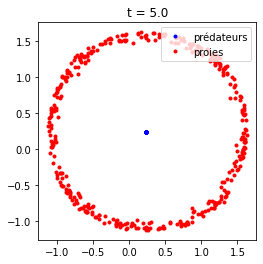

In [3]:
# Paramètres sauvegardes :
cnt     = 0 # Compteur boucle
cnt_sav = 0 # Compteur sauvegardes
sav     = 10 # Pas de sauvegarde

# Création du fichier pour la sauvegarde des figures :
if not os.path.exists('./figures6'):
    os.makedirs('./figures6')

for n,k in enumerate(linspace(0,T,nT+1)):

    ## Interactions des prédateurs
    x1Diff = matl.repmat(x1,1,N1) - matl.repmat(x1.T,N1,1)
    y1Diff = matl.repmat(y1,1,N1) - matl.repmat(y1.T,N1,1)
    norm1Diff = sqrt( x1Diff**2 + y1Diff**2 )
    # Pour éviter les divisions par 0 :
    norm1Diff = norm1Diff*(norm1Diff>0)+1*(norm1Diff==0)
    dxS1 = x1Diff * s1prime(norm1Diff) / norm1Diff
    dyS1 = y1Diff * s1prime(norm1Diff) / norm1Diff
    
    ## Interactions interespèces
    x1x2Diff = matl.repmat(x1,1,N2) - matl.repmat(x2.T,N1,1)
    y1y2Diff = matl.repmat(y1,1,N2) - matl.repmat(y2.T,N1,1)
    norm12Diff = sqrt( x1x2Diff**2 + y1y2Diff**2 )
    # Pour éviter les divisions par 0 :
    norm12Diff = norm12Diff*(norm12Diff>0)+1*(norm12Diff==0)
    dxK = x1x2Diff * kprime(norm12Diff) / norm12Diff
    dyK = y1y2Diff * kprime(norm12Diff) / norm12Diff
    
    ## Interactions des proies
    x2Diff = matl.repmat(x2,1,N2) - matl.repmat(x2.T,N2,1)
    y2Diff = matl.repmat(y2,1,N2) - matl.repmat(y2.T,N2,1)
    norm2Diff = sqrt( x2Diff**2 + y2Diff**2 )
    # Pour éviter les divisions par 0 :
    norm2Diff = norm2Diff*(norm2Diff>0)+1*(norm2Diff==0)
    dxS2 = x2Diff * s2prime(norm2Diff) / norm2Diff
    dyS2 = y2Diff * s2prime(norm2Diff) / norm2Diff  
    
    # Calcul des sommes du système différentiel :
    dx1 = - sum(dxS1, axis=1)/N1 - sum(dxK, axis=1)/N2
    dy1 = - sum(dyS1, axis=1)/N1 - sum(dyK, axis=1)/N2
    dx2 = - sum(dxS2, axis=1)/N2 - alpha * sum(dxK.T, axis=1)/N1
    dy2 = - sum(dyS2, axis=1)/N2 - alpha * sum(dyK.T, axis=1)/N1
       
    # Evolution des positions (via Euler explicite)
    x1 += dt*dx1.reshape(N1,1)
    y1 += dt*dy1.reshape(N1,1)
    x2 += dt*dx2.reshape(N2,1)
    y2 += dt*dy2.reshape(N2,1)
   
    # Sauvegarde de la solution à chaque pas de sauvegarde :
    if (cnt%sav == 0):
        # Plot the data 
        clf() # Efface la figure courante
        plot(x1, y1, 'b.', label="prédateurs")
        plot(x2, y2, 'r.', label="proies")
        plt.legend(loc="upper right")
        #plt.xlim([0, .5])
        #plt.ylim([0, .5])
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title("t = "+str(round(k,3)))
        savefig('figures6/{:03d}.pdf'.format(cnt_sav))
        cnt_sav += 1

    cnt +=1

En prenant des conditions initiales sur une droite, on peut aussi comparer les résultats à ceux obtenus avec le modèle continu en 1D. Pour compter les points sur un axe et former des histogrammes, on peut avoir recours à la fonction _hist_ de _matplotlib.pyplot_.